# Import


In [1]:
import torch
import torch.nn as nn #layers, loss functions...
import torch.nn.functional as F
import torch.optim as optim #optimization method
import torchvision
from torch.utils.data import DataLoader #convert dataset into patches
from torchvision import datasets, transforms #to access datasets and transformation to apply
import numpy as np
import random
import matplotlib.pyplot as plt #visualizing


# Set up Seed


In [ ]:
# Set the seed so that in CPU, GPU nothing is going to be fully random
# and model behave the same throughout training
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## Checking to make sure using GPU

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
NVIDIA GeForce RTX 5070 Ti
Using device: cuda


C:\Users\phant\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5070 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


# Set up Hyperparameters

In [4]:
# Setting the hyperparameters
# All of these can be changed to experiment and tune the model

BATCH_SIZE = 128       # Number of images to process at once (higher = faster but uses more memory). Common to use powers of 2
EPOCHS = 10            # Number of full passes through the training dataset (entire dataset pass through = 1 epoch)
LEARNING_RATE = 3e-4   # Controls how much the model updates weights each step. Smaller = slower but more stable learning

PATCH_SIZE = 4         # Size of each image patch (4x4). Usually it would be 16x16 but since this image is pretty small we split it into 4x4

NUM_CLASSES = 10       # Output dimension of classifier. CIFAR-10 has 10 categories

IMAGE_SIZE = 32        # Width/Height of input image (CIFAR-10 = 32x32)
CHANNELS = 3           # Number of color channels (RGB = 3)

EMBED_DIM = 256        # Dimension of each patch embedding (token). Core size of all token vectors, control the dim throughout
NUM_HEADS = 8          # Number of attention heads. Splits each token into 8 parts for multi-head self-attention
DEPTH = 6              # Number of transformer encoder blocks (layers stacked in the model). Each layer is a full block that contain everything

MLP_DIM = 512              # Hidden dimension inside the MLP block in each transformer layer (usually 2–4× EMBED_DIM)
DROP_RATE = 0.1        # Dropout probability — randomly drops some activations to prevent overfitting


# Define Image Transformation

In [ ]:

# Define Image Transformations
transform = transforms.Compose([ # Container chains multiple image transformation together
    transforms.ToTensor(), # Convert PIL images to Pytorch tensors so we can pass them to the model
    transforms.Normalize((0.5),(0.5)) # Normalize the images. Shift the value to [-1.0, 1.0]
    # this make the model more stable, faster to converge 
    # (is when it reach a decent good spot - not always the best )
    # help introduce negative number which will help with the gradient, activation steps,...
])


# Getting datasets and view it

In [6]:
# Getting a Dataset

train_dataset = datasets.CIFAR10(root = "data", # where the data save at
                                 train = True, # get the train or the test data
                                 download = True, # true to download
                                 transform = transform) # apply what transformation and use the one we create up there


test_dataset = datasets.CIFAR10(root = "data",
                                train = False,
                                download = True,
                                transform = transform)



In [7]:
train_dataset


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [8]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

# Converting datasets to dataloader
- Right now the data is in form of PyTorch Datasets
- Dataloader will turn our data into batches (mini-batches)
#### Why?
- More computationally efficient, less work for the hardware since it might not be able to look (store in memory) at 50000 images in one hit. So we break it into 128 images at a time (batch_size = 128)
- Give neural network more chances to update its gradients per epoch

In [9]:
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False) # not shuffle with the test data


In [10]:
# Check the dataloader
print(f"Data Loader:  { train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {train_loader.batch_size}")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}")

Data Loader:  (<torch.utils.data.dataloader.DataLoader object at 0x000001ED495F8590>, <torch.utils.data.dataloader.DataLoader object at 0x000001ED495E8CD0>)
Length of train_loader: 391 batches of 128
Length of test_loader: 79 batches of 128


# Building Vision Transformer Model from Scratch


# Preparing the data
## Transforming the images into tokens (input embedding + positional embedding)

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__() # Initialize the class so we can use all features from nn.Module (PyTorch base class)
        self.patch_size = patch_size # Save the patch size (4x4 here). We will use this to split the image

        self.proj = nn.Conv2d(
            in_channels=in_channels,    # Number of input channels (CIFAR-10 = 3 for RGB)
            out_channels=embed_dim,     # Number of output channels (the embedding dimension for each patch vector)
            kernel_size=patch_size,     # Size of the patch (e.g., 4) → creates patches of 4x4
            stride=patch_size           # Move the kernel by patch size. so here each patch is 4x4 and we are moving 4 pixel at the time so there will not be any overlapping patches
        )
        # Use a convolution to split the image into non-overlapping patches
        # Each patch gets projected into a vector of size EMBED_DIM (this acts like linear projection for each patch)

        num_patches = (img_size // patch_size) ** 2 # Calculate how many patches per image. CIFAR-10: 32x32 / 4x4 = 8x8 = 64 patches

        # Create a special CLS token (learnable vector) that will represent the entire image at the end
        # 1x1x256 — 1 batch, 1 token, 256 features
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
       
        # Positional embedding: tell the model the position of each patch (including CLS token)
        # Shape = (1, 65, 256) → 64 patches + 1 CLS = 65 total positions
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))


    def forward(self, x:torch.Tensor): # x is a batch of images and in this case 128 and have the shape (128, 3, 32, 32) - 128 images, 3 channels, 32H, 32W
        B = x.size(0) # this is taking out the first value in that order so 128

        x = self.proj(x) # apply linear projection onto this batch of images transform the shape into (128, 256, 8, 8) - 128 images, 1x256 vector to represent each 4x4 patch (token size), 8 patches across W, 8 patches across H -> 64 patches per image

        # Step 1: flatten(2) → merge last two dims (8x8) into one
        # Shape goes from (B, 256, 8, 8) → (B, 256, 64)
        # Now we have 64 patch tokens per image, but still in (feature, token) format        

        # Step 2: transpose(1, 2) → swap channel and token dimension
        # Shape becomes (B, 64, 256)
        # This makes it: 64 tokens per image, each with a 256-dim embedding
        # Final shape is (batch_size, num_patches, embed_dim)
        # This is the required input shape for transformer encoders

        x = x.flatten(2).transpose(1,2)

        # Copy this CLS token and assign to each image. - 1 means keep that number the same so we are increasing the first one into B which is 128
        # by doing expand you are not wasting any memory space because these are not real copies they still point to the same original cls token, just for views
        # later on when add these cls token into the image tensor then it will allocate its new memory but for now you will not waste any
        cls_token = self.cls_token.expand(B, -1, -1)


        # it take the shape of CLS token and x and concatenating them together along the position 1 in the dimension.
        # cls token has shape (128,1,256) x has (128,64,256) so this will make x become (128,65,256)
        # at this step the cls token vector is real and will allocate memory
        # we have to do the expand is because .cat() require all tensors to have the same batch dimension
        x = torch.cat((cls_token,x), dim = 1)


        x = x + self.pos_embed # adding the position embedding value into x just normal math 1 to 1
        return x


# Putting it through the transformer encoder 
## MLP block for self-refinement

In [12]:
# Module is base class for all neural network modules
# Your model should subclass this class
# This is the Feed Forward network step
# At this step, we already have all the attentions from each tokens. This step helps each token to improve itself
class MLP(nn.Module):
    def __init__(self,
                 in_features, # input size
                 hidden_features, # the hidden layer size
                 drop_rate): # how much dropout to apply this is to prevent overfitting
        
        super().__init__()

        # Fully Connected 1 is where we increase the dimension of the vector fc1(x) = xW + b. x will be 1x256, W or Weight will be 256x512, b or bias will be 1x512 this will increase the size of the token to 512
        # Weights and bias are automatically created when we call nn.Linear. Both are learnable and will be updated during training
        self.fc1 =  nn.Linear(in_features= in_features, # in 256
                           out_features= hidden_features) # out 512
        
        # Fully Connected 2 is where we take the large hidden layers and shrink it down to its original size
        self.fc2 = nn.Linear(in_features= hidden_features, # in 512
                             out_features= in_features) # out 256
        
        # This is called Regularization step- randomly sets some value to 0 to prevent the model from relying too much on specific value
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        # First it will put the token through fc1 then apply activation function onto it. we import torch.nn.functional as F and we are using activation function GELU for this (a softer version of ReLU)
        # Then we apply regularization on to it
        x = self.dropout(F.gelu(self.fc1(x))) 

        # Then we override x itself again putting it through fc2 and then apply regularization on it
        x = self.dropout(self.fc2(x))
        return x

        

## Building a Transformer Encoder Layer


In [13]:
# This is 1 Transformer Encoder block. We will stack many of these later (like DEPTH = 6 means 6 of these blocks)
class TransformerEncoderLayer(nn.Module):
    def __init__(self, 
                 embed_dim,   # The dimension of the token (like 256)
                 num_heads,   # How many heads for multi-head attention
                 mlp_dim,     # Hidden size inside the MLP block (e.g. 512)
                 drop_rate):  # Dropout rate to avoid overfitting
        
        super().__init__()

        # First we apply Layer Normalization to stabilize training — this is like smoothing out the data
        self.norm1 = nn.LayerNorm(embed_dim)

        # Then we apply Multi-head Self Attention — this is the step where each token will attend to all other tokens in the image
        # It takes 3 inputs: Query, Key, and Value — in ViT we use the same token for all 3
        # dropout is also applied inside here
        # batch_first = True because our input shape is (batch_size, num_tokens, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)

        # After attention, we normalize again before going into the MLP block
        self.norm2 = nn.LayerNorm(embed_dim)

        # MLP block — this helps each token refine itself after the attention step
        # It uses the GELU activation and dropout that we defined earlier
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)


    def forward (self, x):
        # Step 1: we normalize all the input vectors. Attention requires Q, K, and V and it is all the same here which is norm1(x)
        # Step 2: we apply self attention onto these 3 vectors and the output will be [attn_outputs, attn_weights] and we only want the outputs so [0].
        # attn_weights to see how does each token attends to each other but only use this for visualization
        # Step 3: then we add this attention output back to its original self (Residual Connection). This help to keep the original information and adds new learned info
        x = x + self.attn(self.norm1(x),self.norm1(x), self.norm1(x))[0]

        # Same here: we apply the normalization again before sending it to mlp then we use residual connection for this 
        x = x + self.mlp(self.norm2(x))

        return x

# Vision Transformer


In [14]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()

        # This handles the image patch splitting, linear projection, CLS token, and position embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # This builds a stack of TransformerEncoderLayer blocks (how many = depth)
        # Each block includes: LayerNorm → Attention → MLP + residual
        # [] This creates a list of TransformerEncoderLayer instances depends on how many depth
        # the * helps to unpack them and feed them 1 by 1 like having a bag of candy instead of giving them all at once, give each candy at a time
        # the result will be reused after each layer: layer 2 will use result from layer 1 and so on
        # have to follow this syntax and put the for after the function. this is called list comprehension follow this form [expression for item in iterable]
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])

        # Final normalization layer after all encoder layers
        self.norm = nn.LayerNorm(embed_dim)

        # Final classification head (MLP): takes the CLS token and maps to 10 output classes
        # Here it performs a linear transformation from 256 value-vector to a 10 value-vector since we have 10 classes. 1 image will be a vector of 10 with each value related to the 10 class
        # Follow the same format as any other linear transformation so Weight and bias will also start out as random and will be updated later through backpropagation
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)       # Step 1: Convert image into tokens + CLS + positional embedding
        x = self.encoder(x)           # Step 2: Pass through stacked Transformer blocks
        x = self.norm(x)              # Step 3: Apply final LayerNorm after encoder stack
        cls_token = x[:, 0]           # Step 4: Extract the CLS token. So x has shape (batch_size, num_tokens, embed_dim) by using : means all rows (all 128 images in a batch)
                                        # 0 in the second position means take the first token and since we push CLS to the first position in the num_token, we wil get 128 CLS
        return self.head(cls_token)   # Step 5: Pass CLS token into final classifier → output: (batch_size, num_classes)


In [15]:
DEPTH

6

In [16]:
device

device(type='cuda')

In [17]:

# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

# Starting the model and send it to the GPU

In [18]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

# Defining Optimizer and Loss Function

In [19]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is.
# This is the loss function where it applies softmax to the logits (the output of the self.head()) so that it wil turn to probabilities that correlate with the classes (all will add up to 1)
# Then it will compare to the true label. It will apply a negative log to the correspond position value in the vector. The lower the result the better. Output will be a single number


# This is optimizer and we use "Adam (a optimization method)" to help update every single trainable parameters in the model
# model.parameter grabs all the learnable parameters (weights and biases) in my model 
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

# Training Loop Setup 
## Main stuff here

### Training mode

In [20]:
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    # PyTorch layers like dropout or layernorm are mode-aware. They only behave correctly if they are in the right mode
    # You just need to activate this when we want to train the model make sure its the right mode
    model.train()

    # Loss tells you how wrong the model is. Each image has one loss, and the batch loss is the average of all image losses in that batch (e.g., 128 images).
    # total_loss accumulates the scaled batch losses across all batches so we can compute the final average loss for the whole epoch.
    # correct keeps track of how many predictions were correct (used to calculate accuracy later).
    total_loss, correct = 0, 0

    # CIFAR10 return data in the form (input, target) so in here x will be inputs and y will be labels
    # Here it is looping through each batch with its correspond labels
    for x, y in loader:
        
        # Moving (Sending) our data into the target device (GPU)
        # Have to also move the data to the GPU otherwise the model is on GPU and data is on CPU, they can't communicate
        x, y = x.to(device), y.to(device)
        
        # Resetting the gradient value each time we run a new batch since we don't to accumulate it through each time which will lead to wrong result
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        # This step is basically get the logits output of each image
        out = model(x)

        # 2. Calculate loss (per batch)
        # It applies softmax to the logits value then compare it to "y" which is the true label
        loss = criterion(out, y)
        
        # 3. Perform backpropagation
        # Traverse the entire computational graph. When we call model(x), it already put all the function that we create into like a same bag and PyTorch will build a computation graph behind it
        # Every single steps that requires to have weights and bias will have their own W and b whenever we created them using PyTorch so when the system traverse,
        #  the gradient value of each will be save in a .grad in that function behind the scene
        loss.backward()

        # 4. Perform Gradient Descent
        # This is the step where PyTorch updates all the model's parameters (weights and bias).
        # It looks at the .grad value for each parameter (calculated from loss.backward()).
        # Then it adjusts the weights and biases slightly to reduce the loss — this is called Gradient Descent.
        # In simple terms, it moves the weights in the direction that makes the model less wrong (closer to the correct answer).
        # optimizer and criterion are linked to each other is because when we create optimizer we called model.parameter which make optimizer connects to all the parameter
        #  and since we are saving .grad in the parameter it can access that gradient value
        optimizer.step()

        # the .item() helps to convert tensor value into a Python number even since loss is already a single number but still it was in tensor format
        # the loss we calculate above are actually the average loss of the whole batch so now we are multiplying back with the batch size to get the actual loss value 
        total_loss += loss.item() * x.size(0)

        # here we first use argmax(1) which mean look across dimension 1 since out has (128, 10) [128 rows, each with 10 softmax value from logits] so dimension 1 is the 10 part
        # if the highest in the 10 value match with the position from the label (the highest softmax value guess correctly) we will sum it and turn it into a number using .item()
        correct += (out.argmax(1) == y).sum().item()

    # len(loader.dataset) is the total number of image in the entire dataset, not just this batch.
    # This will return the average loss for each image for each epoch and overall accuracy
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

### Evaluation Mode

In [21]:
# This is a evaluation mode. You use this to check the trained model above with new set of images (from testing datasets) to see how well the model is doing

def evaluate(model, loader):
    # First we set the model into evaluation mode so that it turn off all the randomness stuff like dropout or layer norms since we already do these steps at the training steps
    # We need the model to be stable, doesn't change anything so that we can test it out correctly
    model.eval() 

    correct = 0

    # Turning off gradient tracking to save memory since we already compute these gradient value in the training step, we don't need to keep track of it anymore
    with torch.inference_mode():
        
        # x and y here is image batch and labels from the testing datasets
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # this will get the logits value from the testing datasets. this is a different x a testing x.
            #  We basically take the trained model and run it straight (no update, no training) to get the logits value from a testing data
            out = model(x)

            # Calculate the accuracy of the model
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [22]:
EPOCHS

10

In [23]:
from tqdm.auto import tqdm
     

### Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")
     

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Train loss: 1.7336, Train acc: 0.3718%, Test acc: 0.4793
Epoch: 2/10, Train loss: 1.3802, Train acc: 0.5035%, Test acc: 0.5353
Epoch: 3/10, Train loss: 1.2368, Train acc: 0.5582%, Test acc: 0.5687
Epoch: 4/10, Train loss: 1.1327, Train acc: 0.5947%, Test acc: 0.5813
Epoch: 5/10, Train loss: 1.0375, Train acc: 0.6308%, Test acc: 0.6064
Epoch: 6/10, Train loss: 0.9659, Train acc: 0.6572%, Test acc: 0.6103
Epoch: 7/10, Train loss: 0.8921, Train acc: 0.6815%, Test acc: 0.6231
Epoch: 8/10, Train loss: 0.8135, Train acc: 0.7098%, Test acc: 0.6292
Epoch: 9/10, Train loss: 0.7454, Train acc: 0.7357%, Test acc: 0.6338
Epoch: 10/10, Train loss: 0.6803, Train acc: 0.7584%, Test acc: 0.6338


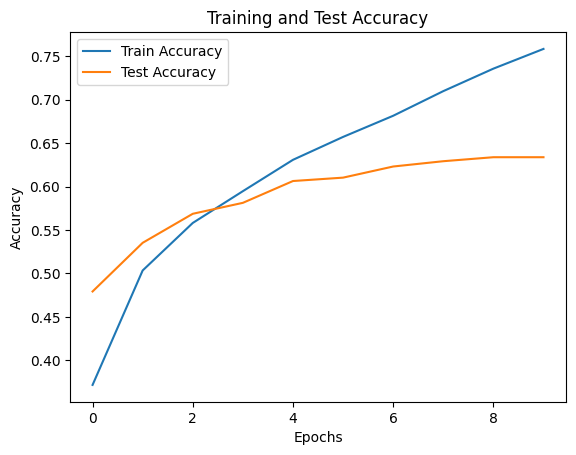

In [24]:
train_accuracies
     

test_accuracies
     

# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()
     

import random
     

len(test_dataset)
     

test_dataset[0][0].unsqueeze(dim=0).shape
     

test_dataset[0][0] / 2 + 0.5
     

def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

In [25]:
import matplotlib.pyplot as plt
import torchvision

# Make sure you already have this defined
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def show_batch_predictions(model, dataloader, num_images=16):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(12, 12))

    with torch.inference_mode():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(x_batch)
            preds = outputs.argmax(dim=1)

            for i in range(x_batch.size(0)):
                if images_shown >= num_images:
                    break
                image = x_batch[i].cpu()
                label = y_batch[i].item()
                pred = preds[i].item()

                plt.subplot(4, 4, images_shown + 1)
                plt.imshow(image.permute(1, 2, 0))  # C, H, W → H, W, C
                plt.title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input d

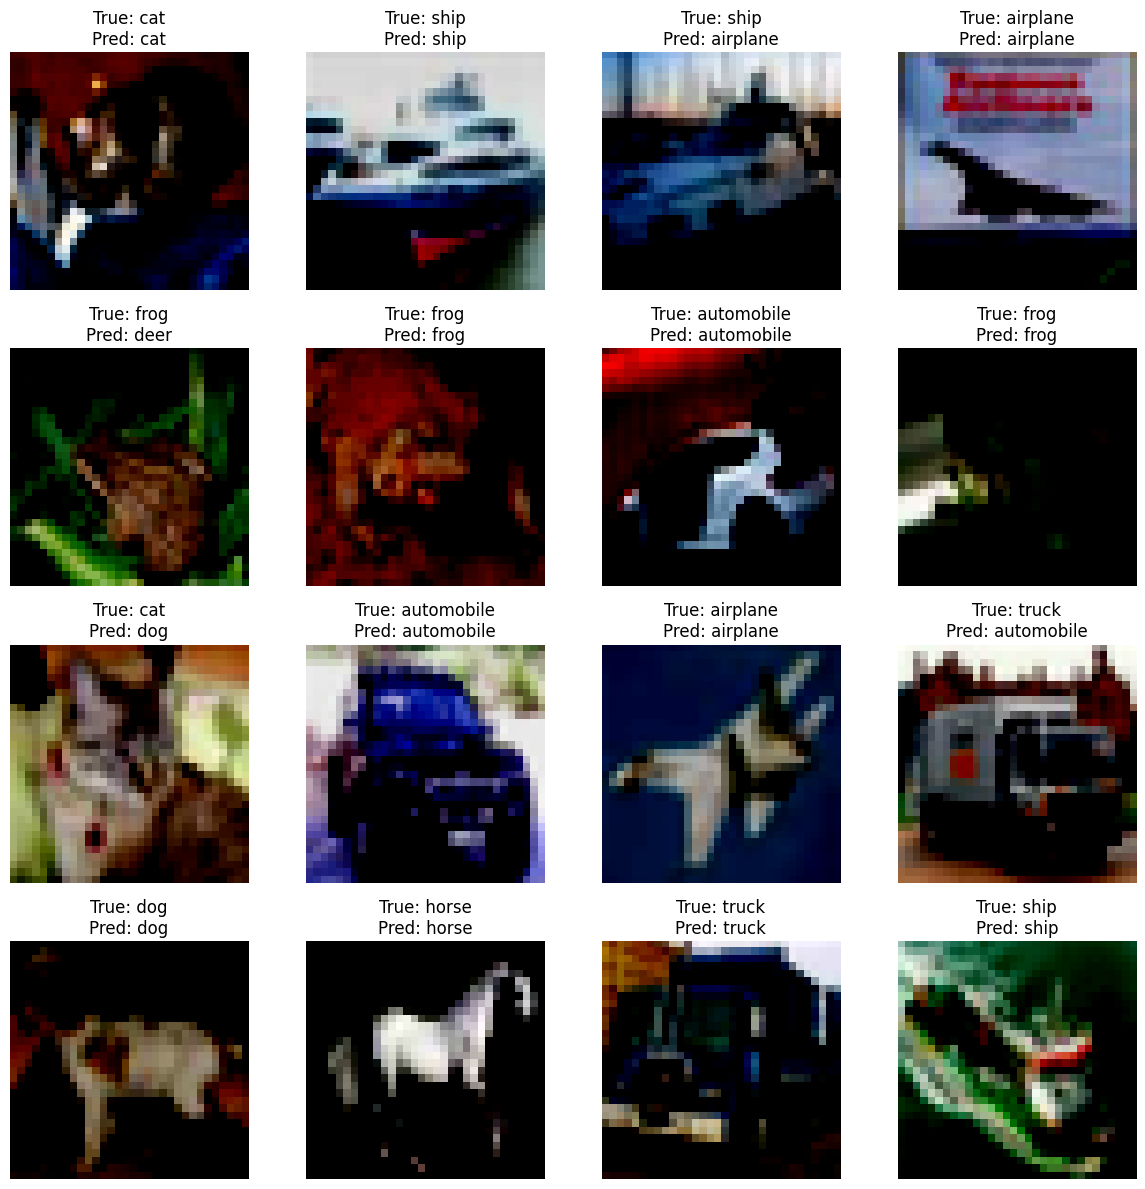

In [26]:
show_batch_predictions(model, test_loader, num_images=16)
